In [1]:
using GaussianFilters

using LinearAlgebra
using Distributions
using Random

Random.seed!(1);

## Build PHD Filter

In [2]:
# parameters
σ_p = 1.0     # Standard deviation - process noise
σ_m = 1.0    # Standard deviation - measurement noise
Δ = 1       # Sampling Period
r = 50      # surveillanve region (square with side length 2*r)
v = 5   # expected velocity of target entering/leaving
tf = 100;

In [3]:
# Dynamics Model - Gaussian
F = [ Matrix{Float64}(I,2,2) Δ*Matrix{Float64}(I,2,2) ;
    zeros(Float64,2,2) Matrix{Float64}(I,2,2) ]
Q  = σ_p^2 * [ (Δ^4)/4*Matrix{Float64}(I,2,2) (Δ^3)/4*Matrix{Float64}(I,2,2) ;
            (Δ^3)/4*Matrix{Float64}(I,2,2) (Δ^2)*Matrix{Float64}(I,2,2) ]
Dyns = Dynamics(F,Q);

In [4]:
# Measurement Model
C = [ Matrix{Float64}(I,2,2) zeros(Float64,2,2) ]
R = σ_m^2 * Matrix{Float64}(I,2,2)
Meas = Measurement(C,R);

In [5]:
# birth (spontaneous) model
w_γ = 0.01
m_γ1 = [ -r, 0, v, 0]
m_γ2 = [  r, 0,-v, 0]
m_γ3 = [  0,-r, 0, v]
m_γ4 = [  0, r, 0,-v]
P_horz = Matrix(Diagonal([1 , 100, 1, 5]))
P_vert = Matrix(Diagonal([100,  1, 5, 1]))
γ = GaussianMixture([w_γ, w_γ, w_γ, w_γ] , [m_γ1, m_γ2, m_γ3, m_γ4] ,
                    [P_horz, P_horz, P_vert, P_vert]);

In [6]:
# Spawn (from existing targets) model
w_β = 0.01
Q_β = Matrix(Diagonal([1.0 , 1.0 , 5.0 , 5.0]))
β = GaussianMixture([w_β] , [[0.0,0.0,0.0,0.0]] , [Q_β])
spawn = Spawn(β, [Dyns]);

In [7]:
# Clutter model
λ_c = 12.5*10^-6    # Average clutter returns per unit volume
κ(z) = λ_c;

In [8]:
# Build PHD Object
T = 10^-5   # Truncation threshold
U = 4       # Merging threshold
J_max = 10  # Max number of Gaussian terms
Ps = 0.99   # Probability of survival
Pd = 0.99   # Probability of detection

phd = PHDFilter(γ,spawn,[Dyns],Meas,Ps,Pd,κ);

## Simulate System

In [9]:
# simulate system
function simulateSystem(Dyns,meas,tf,dt,r)

    F = Dyns.A
    Q = Dyns.Q

    C = meas.C
    R = meas.R

    # Define initial states
    x0_ac = [-40., 20]
    x0_ap1 = [0., -50., -0.5, 5.]
    x0_ap2 = [-100., 0., 5., 1.]

    # simulate system
    t_arr = range(0, stop=tf, step=dt)

    x_ac_arr = [[x,(x-20)^2/160] for x in -40:-40+tf]

    x_ap1_arr = [x0_ap1]
    x_ap2_arr = [x0_ap2]
    y_arr = []

    x_ap3_t = 20
    x_ap3_arr = []

    x_ap4_t = 35
    x_ap4_arr = []

    dist = MvNormal(Q)
    dist_meas = MvNormal(R)



    for (i,t) in enumerate(t_arr)
        y_step = Array{Real,1}[]

        # simulate aircraft carrier
        x_ac = x_ac_arr[i]
        if all(abs.(x_ac) .< r)
            y_ac = x_ac + rand(dist_meas,1)[:]
            push!(y_step, y_ac)
        end

        # smulate airplane 1
        x_ap1 = x_ap1_arr[i]
        x_ap1_new = F*x_ap1 + rand(dist,1)[:]/5
        if all(abs.(x_ap1) .< r)
            y_ap1 = C*x_ap1 + rand(dist_meas,1)[:]
            push!(y_step, y_ap1)
        end


        # smulate airplane 2
        x_ap2 = x_ap2_arr[i]
        x_ap2_new = F*x_ap2 + rand(dist,1)[:]
        if all(abs.(x_ap2) .< r)
            y_ap2 = C*x_ap2 + rand(dist_meas,1)[:]
            push!(y_step, y_ap2)
        end

        # spawn and simulate airplane 3
        if t == x_ap3_t
            x_ac_new = x_ac_arr[i+1]
            x_ap3_new = vcat(x_ac_new,[1,0.5])
            push!(x_ap3_arr,x_ap3_new)
        elseif t > x_ap3_t
            i_adj = i - x_ap3_t-1
            x_ap3 = x_ap3_arr[i_adj]
            x_ap3_new = F*x_ap3 + rand(dist,1)[:]/5
            if all(abs.(x_ap3) .< r)
                y_ap3 = C*x_ap3 + rand(dist_meas,1)[:]
                push!(y_step, y_ap3)
            end
            push!(x_ap3_arr,x_ap3_new)
        end


        # spawn and simulate airplane 4
        if t == x_ap4_t
            x_ac_new = x_ac_arr[i+1]
            x_ap4_new = vcat(x_ac_new,[1,-0.5])
            push!(x_ap4_arr,x_ap4_new)
        elseif t > x_ap4_t
            i_adj = i - x_ap4_t-1
            x_ap4 = x_ap4_arr[i_adj]
            x_ap4_new = F*x_ap4 + rand(dist,1)[:]/5
            if all(abs.(x_ap4) .< r)
                y_ap4 = C*x_ap4 + rand(dist_meas,1)[:]
                push!(y_step, y_ap4)
            end
            push!(x_ap4_arr,x_ap4_new)
        end


        push!(x_ap1_arr,x_ap1_new)
        push!(x_ap2_arr,x_ap2_new)
        push!(y_arr, y_step)
    end

    return x_ac_arr, x_ap1_arr, x_ap2_arr, x_ap3_arr, x_ap4_arr, y_arr
end

x_ac_truth, x_ap1_truth, x_ap2_truth, x_ap3_truth, x_ap4_truth, y_arr = simulateSystem(Dyns, Meas, tf, Δ, r);

## Run Filter and Extract States

In [10]:
# Define our initial Gaussian mixture belief
w_target1 = 0.9;
mu_target1 = [-40., 20, 1, 0]
sigma1 = Matrix(Diagonal([5.0 , 5.0 , 1.0 , 1.0]))

w_target2 = 0.5;
# mu_target2 = [20., 20., 0., 5.] #+ rand(MvNormal(Q),1)[:]
mu_target2 = [0., -50., -0.5, 5.] + rand(MvNormal(Q),1)[:]
sigma2 = Matrix(Diagonal([1.0 , 1.0 , 1.0 , 1.0]))

GM0 =  GaussianMixture([w_target1, w_target2] , [mu_target1, mu_target2] ,
                    [sigma1, sigma2]);


In [11]:
# Run PHD filter
GM_arr = [GM0]
for (i,t) in enumerate(1:Δ:tf)
    y = y_arr[i]    # get current measurements
    GM_new = update(phd,GM_arr[t], y, T, U, J_max)
    push!(GM_arr, GM_new)
end


In [12]:
# extract states from GM_arr
x_est = []
for (i,GM) in enumerate(GM_arr)
    x = multiple_target_state_extraction(GM,0.5)
    push!(x_est,x)
end

### Plot

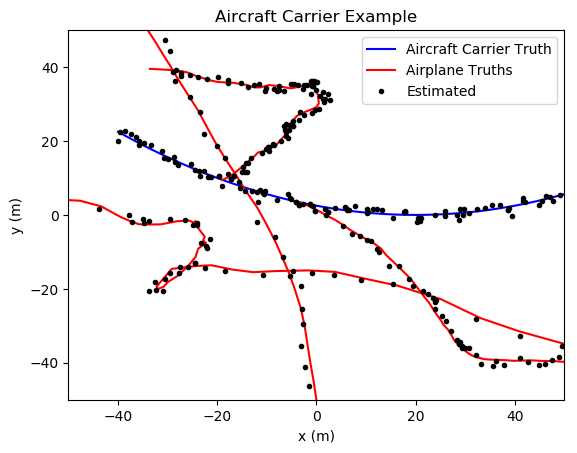

C:\Users\Saint Pablo\.julia\conda\3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


In [13]:
using PyPlot

figure()
## plot truths
# aircraft carrier
x = [k[1] for k in x_ac_truth]
y = [k[2] for k in x_ac_truth]
plot(x,y,label="Aircraft Carrier Truth","b")

# airplane 1
x = [k[1] for k in x_ap1_truth]
y = [k[2] for k in x_ap1_truth]
plot(x,y,label="Airplane Truths","r")

# airplane 2
x = [k[1] for k in x_ap2_truth]
y = [k[2] for k in x_ap2_truth]
plot(x,y,"r")

# airplane 3
x = [k[1] for k in x_ap3_truth]
y = [k[2] for k in x_ap3_truth]
plot(x,y,"r")

# airplane 4
x = [k[1] for k in x_ap4_truth]
y = [k[2] for k in x_ap4_truth]
plot(x,y,"r")

## plot estimates
for x in x_est
    for mu in x
        plot(mu[1],mu[2],"k.")
    end
end

## Formatting
title("Aircraft Carrier Example")
xlabel("x (m)")
ylabel("y (m)")

plot([],[],label="Estimated","k.")

legend()
xlim(-50,50)
ylim(-50,50)
show()